### Importing the basic necessities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

### Reading the dataset

In [6]:
sms = pd.read_csv("spam.csv",encoding='latin-1')
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

In [7]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
sms['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

So we have `4825` ham and `747` spam messages

In [9]:
sms['label_num'] = sms['label'].map({'ham': 0, 'spam': 1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Let's add a basic feature 'message length' to our dataset. You may find many advanced feature engineering techniques for spam classification problem but at the end it all boils down to your domain knowledge and expected accuracy of results. For now, we will add only this feature

In [10]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

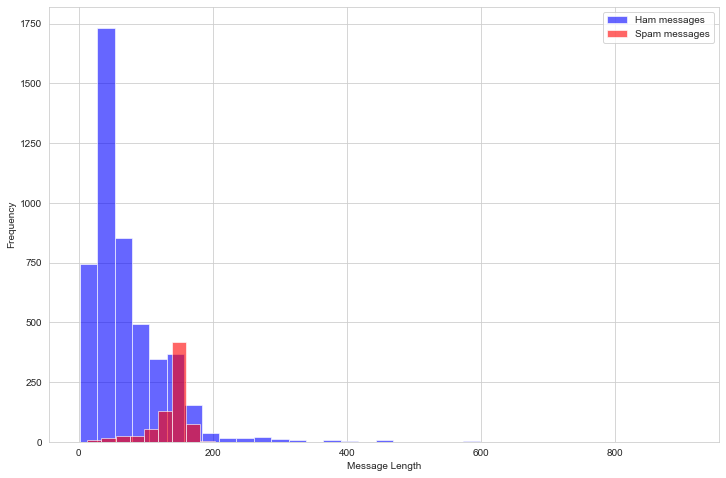

In [11]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

It appears that spam messages are usually longer than ham messages. Let's check out each category separately to get a numeric view on this

In [12]:
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [13]:
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


As we can see above, 75% of the ham messages have length less than 92 characters whereas 75% of the spam messages have length more than 132 characters. So basically, if you just judge a message by its length, you would be right 75% of the time.
**Pretty Interesting, isn't it?**

### Text Pre-Processing

Before we get into any kind of machine learning classification models, let's clean our messages of `punctuation` and `stopwords`. The former is pretty obvious to everyone, but for those who are not familiar with the latter one, /*stopwords*/ are commonly occuring words found in any launguage text which help form continuity and structure but attribute no particular or unique meaning to the sentence, for e.g. "The","is","at", etc. Python's `nltk` library has a list of stopwords that we can use to filter out these.

In [104]:
import string
from nltk.corpus import stopwords

def text_process(message):
    """
    Takes in a string of text and remove punctuation & stopwords
    Return type: string
    Returns: String of cleaned message
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

Let's apply the above function and create a new field having clean messages

In [105]:
sms['clean_message'] = sms['message'].apply(text_process)

In [106]:
sms.head()

,label,message,label_num,message_len,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


Let's take a look at what are the most commonly occuring words in each category of messages

In [112]:
from collections import Counter

# Splitting sentences into tokens
ham_tokenized = sms[sms.label=='ham']['clean_message'].apply(lambda x: [word.lower() for word in x.split()])
spam_tokenized = sms[sms.label=='spam']['clean_message'].apply(lambda x: [word.lower() for word in x.split()])

# Creating counter objects for keeping track of token frequency
ham_words = Counter()
spam_words = Counter()

# Iterating and updating counter for all messages in the category
for msg in ham_tokenized:
    ham_words.update(msg)
for msg in spam_tokenized:
    spam_words.update(msg)
    
print("Top 10 words in ham messages are:\n",ham_words.most_common(10))
print("\nTop 10 words in spam messages are:\n",spam_words.most_common(10))

Top 10 words in ham messages are:
 [('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224)]

Top 10 words in spam messages are:
 [('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83)]


If we observe the above results, we can see that there are different forms of the same root word getting repeated, such as "get"-"got","come"-"go". As these hold similar significance in a message from a spam/ham classification perspective, let's just reduce every word to its root word (aka `stem`) using the `Porter Stemmer`. If you need more background on the difference between `lemmatization` and `stemming`, when to use which, and how to implement it, feel free to browse this link from [Datacamp](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

Let's redefine out `text_process` function incorporating Stemming in there. This time we will also use nltk's `tokenize` function to convert strings into tokens instead of our normal split methodology

In [108]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def text_process_stem(message):
    """
    Takes in a string of text and performs the following steps:
    1. Remove punctuation
    2. Tokenize
    3. Remove stopwords
    4. Stems words to their root forms
    Return type: string
    Returns: String of cleaned & stemmed message
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again to form the string
    nopunc = ''.join(nopunc)
    
    # Instantiating a PorterStemmer object
    porter = PorterStemmer()
    token_words = word_tokenize(nopunc)
    stem_message=[]
    for word in token_words:
        stem_message.append(porter.stem(word))
        stem_message.append(" ")
    return ''.join(stem_message)

In [109]:
sms['clean_message_stem'] = sms['message'].apply(text_process)
sms.head()

,label,message,label_num,message_len,clean_message,clean_message_stem
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though,Nah think goes usf lives around though


### Model Build & Testing

The classification alogrithms we would be using for our problem usually work with numerical feature vector. For that reason, we will need to convert our messages into numerical features. There are multiple methods to convert a corpus of text into a numerical vector, simplest of which is `bag-of-words` approach, where each sentence is expressed using a bag of words that we call `vocabulary` and every word occurs a number of times in that sentence. For performing this conversion, we will use the `CountVectorizer` available in scikit-learn.

To perform this modelling, we will be subjecting our data to three sequential steps:
1. **Bag-of-Words creation**: We will use the `CountVectorizer` to create word-message matrix with each element representing the freuquency of occurence for that word-message combination. You can imagine it to look like the following table:

| Word/Message | Message 1 | Message 2 | ... | Message N |
| --- | --- | --- | --- | --- |
| Word 1 | 0 | 1 | ... | 1 |
| Word 2 | 2 | 0 | ... | 0 |
| Word 3 | 1 | 1 | ... | 1 |

2. **Transforming using TF-IDF***: TF-IDF stands for "Term Frequency - Inverse Document Frequency", what it does is it positively weighs every term for its occurence in a message and also negatively weighs that term for occuring frequently in general, which results into a normalized weight associated to every token. Taking from the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)
> The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus

3. **Multinomial Naive Bayes Model**: Using the normalized weightages for each word in the corpus as input, we then fit a Naive Bayes classifier model to this data. Naive Bayes works great in spam filtering use case because it assumes that every feature (token in our case) is independently related to the overall outcome. Quoting the official documentation:
> The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Lastly, to evaluate the efficacy of our model we will be using the precision score. The reason for choosing precision is that it penalizes the model for false positives, i.e. in our case classifying a normal/important message as Spam and putting it in Junk. To get a good idea about the different evaluation metrics and when to use them, you can refer to this [article](https://towardsdatascience.com/top-10-model-evaluation-metrics-for-classification-ml-models-a0a0f1d51b9)

Let's split the dataset into train and test sets, followed by creating a machine-learning pipeline comprising the above three steps

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics

X = sms.clean_message
y = sms.label_num
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...ear_tf=False, use_idf=True)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [102]:
y_pred = pipe.predict(X_test)

# Evaluating model
print("Accuracy is: {:2f}".format(metrics.accuracy_score(y_test,y_pred)))
print("Precision is: {:2f}".format(metrics.precision_score(y_test,y_pred)))
print("ROC-AUC is: {:2f}".format(metrics.roc_auc_score(y_test,y_pred)))

Accuracy is: 0.966978
Precision is: 1.000000
ROC-AUC is: 0.872222


That's a good precision but not so good AUC score. Let's try comparing this with logistic regression model

In [103]:
from sklearn.linear_model import LogisticRegression

pipe_log = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('logmodel', LogisticRegression(solver='liblinear'))])
                     
pipe_log.fit(X_train, y_train)

y_pred = pipe_log.predict(X_test)

# Evaluating model
print("Accuracy is: {:2f}".format(metrics.accuracy_score(y_test,y_pred)))
print("Precision is: {:2f}".format(metrics.precision_score(y_test,y_pred)))
print("ROC-AUC is: {:2f}".format(metrics.roc_auc_score(y_test,y_pred)))

Accuracy is: 0.963388
Precision is: 0.977778
ROC-AUC is: 0.865430


# As we see, logistic regression is coming out to be a better model here rather than Naive-Bayes. We could further tune the count vectorizer we are using or the stemming/lemmatization techniques to increase the efficacy of this model. But for now, let's just use this model and build a web app based on it